<a href="https://colab.research.google.com/github/TentaTonny/WhereIsWaldo_Team18/blob/main/Pretraining_Triplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [130]:
from torchvision import datasets, transforms
from torchvision.datasets import DatasetFolder, ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import random
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

In [131]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [133]:
class Patchify(nn.Module):

    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels = 3,
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
         # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

In [134]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [135]:
class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out

In [136]:
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

In [137]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)
        x = self.classifier(x)
        return x

**Data Pre-Processing**

# **Part1 - TRIPLET LOSS**

In [ ]:
#https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch

In [ ]:
#https://medium.com/@Skpd/triplet-loss-on-imagenet-dataset-a2b29b8c2952

In [138]:
class WhereIsWaldoData(ImageFolder):
    def __init__(self, root_path, transformer):
      super().__init__(root_path, transformer)
      self.transformer = transformer
      self.is_train = True #set this to false for testset

    def __getitem__(self, index: int):
      anchor_image_path = self.imgs[index][0]
      anchor_lbl = self.imgs[index][1]

      if self.is_train:
        positive_list = [index for index, sample in enumerate(self.imgs) if sample[1] == anchor_lbl]
        positive_item = random.choice(positive_list)
        positive_img_path = self.imgs[positive_item][0]

        negative_list = [index for index, sample in enumerate(self.imgs) if sample[1] != anchor_lbl]
        negative_item = random.choice(negative_list)
        negative_img_path = self.imgs[negative_item][0]

        if self.transform:
            anchor_img = self.transform(self.loader(anchor_image_path))
            positive_img = self.transform(self.loader(positive_img_path))
            negative_img = self.transform(self.loader(negative_img_path))

        return anchor_img, positive_img, negative_img, anchor_lbl

      else:
          if self.transform:
              anchor_img = self.transform(self.loader(anchor_image_path))
          return anchor_img, anchor_lbl #nis het nodig lbl door te geven?

    def __len__(self) -> int:
        return len(self.samples)



In [139]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [153]:
data_path = '/content/gdrive/MyDrive/Hey-Waldo/'

In [154]:
transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.ToTensor()
                                      ])

In [155]:
# Load datasets
dataset_64 = WhereIsWaldoData(f'{data_path}64', transform_train)
dataset_128 = WhereIsWaldoData(f'{data_path}128', transform_train)

# Combine datasets
combined_dataset = torch.utils.data.ConcatDataset([dataset_64, dataset_128])

In [156]:
anchor_img, positive_img, negative_img, anchor_label = combined_dataset.__getitem__(1)

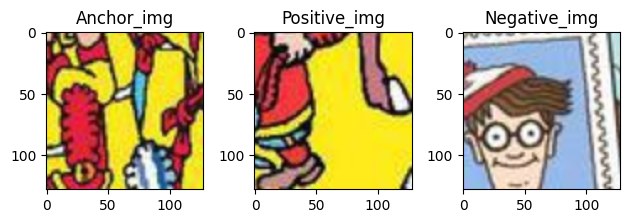

In [157]:
import matplotlib.pyplot as plt

# Assuming you have three tensors: image1, image2, image3

# Plotting the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.imshow(np.transpose(anchor_img, (1, 2, 0)))
plt.title('Anchor_img')

# Plotting the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.imshow(np.transpose(positive_img, (1, 2, 0)))
plt.title('Positive_img')

# Plotting the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.imshow(np.transpose(negative_img, (1, 2, 0)))
plt.title('Negative_img')

plt.tight_layout()  # To ensure proper spacing
plt.show()

In [158]:
from torch.utils.data import DataLoader

# Calculate the sizes for train, validation, and test sets
total_data = len(combined_dataset)
train_val_size = int(0.9 * total_data)
test_size = total_data - train_val_size

# Splitting combined_dataset into train_val_set and test_set
train_val_set, test_set = torch.utils.data.random_split(combined_dataset, [train_val_size, test_size])

# Further splitting train_val_set into train_set and validation_set
train_size = int(0.9 * len(train_val_set))
val_size = len(train_val_set) - train_size
train_set, validation_set = torch.utils.data.random_split(train_val_set, [train_size, val_size])

#disable train on test_set
test_set.is_train = False

# Creating DataLoader for each dataset
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

In [159]:
model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)

random_input = torch.randn(1,3,128,128).to(device)
print(model(random_input).shape)

torch.Size([1, 2])


In [160]:
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = TripletLoss()

In [161]:
print_every = 20
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (anchor_imgs, positive_imgs, negative_imgs, anchor_labels) in enumerate(train_loader):
      anchor_imgs = anchor_imgs.to(device)
      positive_imgs = positive_imgs.to(device)
      negative_imgs = negative_imgs.to(device)
      anchor_labels = anchor_labels.to(device)

      optimizer.zero_grad()
      anchor_out = model(anchor_imgs)
      positive_out = model(positive_imgs)
      negative_out = model(negative_imgs)

      loss = criterion(anchor_out, positive_out, negative_out)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = anchor_out.max(1)
      total += anchor_labels.size(0)
      correct += predicted.eq(anchor_labels).sum().item()

      epoch_loss = train_loss/(batch_idx+1)
      epoch_acc = 100.*correct/total

      if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, len(train_loader),
                                                                                   epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [162]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (anchor_imgs, positive_imgs, negative_imgs, anchor_labels) in enumerate(tqdm(test_loader)):
            anchor_imgs = anchor_imgs.to(device)
            positive_imgs = positive_imgs.to(device)
            negative_imgs = negative_imgs.to(device)
            anchor_labels = anchor_labels.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_imgs)
            positive_out = model(positive_imgs)
            negative_out = model(negative_imgs)

            loss = criterion(anchor_out, positive_out, negative_out)

            test_loss += loss.item()
            _, predicted = anchor_out.max(1)
            total += anchor_labels.size(0)
            correct += predicted.eq(anchor_labels).sum().item()

    acc = 100.*correct/total
    loss = test_loss/(batch_idx+1)
    print('Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(acc, loss))
    return acc

In [163]:
best_acc = 0

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss = train(epoch)
    losses.append(epoch_loss)
    scheduler.step()
    acc = test()
    state = {'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch}

    torch.save(state, f'model.pth_{epoch}')
    best_acc = acc

Epoch 0/50, Iter 0/43, Train Loss: 0.999, Train Accuracy: 45.312
Epoch 0/50, Iter 20/43, Train Loss: 0.987, Train Accuracy: 96.615
Epoch 0/50, Iter 40/43, Train Loss: 0.967, Train Accuracy: 97.809


100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Test Accuracy: 98.661, Test Loss: 0.906
Epoch 1/50, Iter 0/43, Train Loss: 0.838, Train Accuracy: 97.656
Epoch 1/50, Iter 20/43, Train Loss: 0.724, Train Accuracy: 80.990
Epoch 1/50, Iter 40/43, Train Loss: 0.640, Train Accuracy: 89.748


100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Test Accuracy: 99.107, Test Loss: 0.411
Epoch 2/50, Iter 0/43, Train Loss: 0.298, Train Accuracy: 99.219
Epoch 2/50, Iter 20/43, Train Loss: 0.301, Train Accuracy: 92.411
Epoch 2/50, Iter 40/43, Train Loss: 0.276, Train Accuracy: 95.579


100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


Test Accuracy: 91.667, Test Loss: 0.186
Epoch 3/50, Iter 0/43, Train Loss: 0.115, Train Accuracy: 89.844
Epoch 3/50, Iter 20/43, Train Loss: 0.168, Train Accuracy: 92.448
Epoch 3/50, Iter 40/43, Train Loss: 0.155, Train Accuracy: 95.675


100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Test Accuracy: 98.661, Test Loss: 0.129
Epoch 4/50, Iter 0/43, Train Loss: 0.085, Train Accuracy: 100.000
Epoch 4/50, Iter 20/43, Train Loss: 0.106, Train Accuracy: 99.293
Epoch 4/50, Iter 40/43, Train Loss: 0.115, Train Accuracy: 99.047


100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Test Accuracy: 98.661, Test Loss: 0.117
Epoch 5/50, Iter 0/43, Train Loss: 0.061, Train Accuracy: 98.438
Epoch 5/50, Iter 20/43, Train Loss: 0.103, Train Accuracy: 77.381
Epoch 5/50, Iter 40/43, Train Loss: 0.087, Train Accuracy: 88.091


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Test Accuracy: 98.958, Test Loss: 0.103
Epoch 6/50, Iter 0/43, Train Loss: 0.125, Train Accuracy: 100.000
Epoch 6/50, Iter 20/43, Train Loss: 0.077, Train Accuracy: 99.070
Epoch 6/50, Iter 40/43, Train Loss: 0.080, Train Accuracy: 99.009


100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Test Accuracy: 98.958, Test Loss: 0.084
Epoch 7/50, Iter 0/43, Train Loss: 0.088, Train Accuracy: 99.219
Epoch 7/50, Iter 20/43, Train Loss: 0.068, Train Accuracy: 97.507
Epoch 7/50, Iter 40/43, Train Loss: 0.073, Train Accuracy: 97.180


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Test Accuracy: 98.661, Test Loss: 0.142
Epoch 8/50, Iter 0/43, Train Loss: 0.108, Train Accuracy: 98.438
Epoch 8/50, Iter 20/43, Train Loss: 0.061, Train Accuracy: 99.293
Epoch 8/50, Iter 40/43, Train Loss: 0.071, Train Accuracy: 99.123


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Test Accuracy: 99.256, Test Loss: 0.070
Epoch 9/50, Iter 0/43, Train Loss: 0.014, Train Accuracy: 100.000
Epoch 9/50, Iter 20/43, Train Loss: 0.089, Train Accuracy: 99.070
Epoch 9/50, Iter 40/43, Train Loss: 0.072, Train Accuracy: 99.181


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Test Accuracy: 99.256, Test Loss: 0.065
Epoch 10/50, Iter 0/43, Train Loss: 0.020, Train Accuracy: 100.000
Epoch 10/50, Iter 20/43, Train Loss: 0.071, Train Accuracy: 99.293
Epoch 10/50, Iter 40/43, Train Loss: 0.069, Train Accuracy: 99.238


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Test Accuracy: 99.256, Test Loss: 0.076
Epoch 11/50, Iter 0/43, Train Loss: 0.045, Train Accuracy: 100.000
Epoch 11/50, Iter 20/43, Train Loss: 0.050, Train Accuracy: 99.442
Epoch 11/50, Iter 40/43, Train Loss: 0.053, Train Accuracy: 99.143


100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Test Accuracy: 98.661, Test Loss: 0.082
Epoch 12/50, Iter 0/43, Train Loss: 0.101, Train Accuracy: 99.219
Epoch 12/50, Iter 20/43, Train Loss: 0.051, Train Accuracy: 98.958
Epoch 12/50, Iter 40/43, Train Loss: 0.047, Train Accuracy: 99.085


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Test Accuracy: 99.107, Test Loss: 0.108
Epoch 13/50, Iter 0/43, Train Loss: 0.004, Train Accuracy: 99.219
Epoch 13/50, Iter 20/43, Train Loss: 0.059, Train Accuracy: 99.256
Epoch 13/50, Iter 40/43, Train Loss: 0.059, Train Accuracy: 99.162


100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Test Accuracy: 99.107, Test Loss: 0.082
Epoch 14/50, Iter 0/43, Train Loss: 0.068, Train Accuracy: 99.219
Epoch 14/50, Iter 20/43, Train Loss: 0.068, Train Accuracy: 99.144
Epoch 14/50, Iter 40/43, Train Loss: 0.068, Train Accuracy: 99.085


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Test Accuracy: 98.810, Test Loss: 0.058
Epoch 15/50, Iter 0/43, Train Loss: 0.017, Train Accuracy: 99.219
Epoch 15/50, Iter 20/43, Train Loss: 0.053, Train Accuracy: 99.144
Epoch 15/50, Iter 40/43, Train Loss: 0.052, Train Accuracy: 99.009


100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Test Accuracy: 98.661, Test Loss: 0.092
Epoch 16/50, Iter 0/43, Train Loss: 0.012, Train Accuracy: 99.219
Epoch 16/50, Iter 20/43, Train Loss: 0.041, Train Accuracy: 99.293
Epoch 16/50, Iter 40/43, Train Loss: 0.044, Train Accuracy: 99.276


100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Test Accuracy: 99.405, Test Loss: 0.067
Epoch 17/50, Iter 0/43, Train Loss: 0.088, Train Accuracy: 100.000
Epoch 17/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 99.405
Epoch 17/50, Iter 40/43, Train Loss: 0.053, Train Accuracy: 98.761


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Test Accuracy: 99.107, Test Loss: 0.062
Epoch 18/50, Iter 0/43, Train Loss: 0.082, Train Accuracy: 98.438
Epoch 18/50, Iter 20/43, Train Loss: 0.052, Train Accuracy: 99.293
Epoch 18/50, Iter 40/43, Train Loss: 0.050, Train Accuracy: 99.162


100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Test Accuracy: 99.256, Test Loss: 0.063
Epoch 19/50, Iter 0/43, Train Loss: 0.065, Train Accuracy: 99.219
Epoch 19/50, Iter 20/43, Train Loss: 0.048, Train Accuracy: 99.144
Epoch 19/50, Iter 40/43, Train Loss: 0.046, Train Accuracy: 99.143


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Test Accuracy: 98.661, Test Loss: 0.069
Epoch 20/50, Iter 0/43, Train Loss: 0.005, Train Accuracy: 100.000
Epoch 20/50, Iter 20/43, Train Loss: 0.051, Train Accuracy: 99.256
Epoch 20/50, Iter 40/43, Train Loss: 0.050, Train Accuracy: 99.219


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Test Accuracy: 98.661, Test Loss: 0.045
Epoch 21/50, Iter 0/43, Train Loss: 0.078, Train Accuracy: 97.656
Epoch 21/50, Iter 20/43, Train Loss: 0.052, Train Accuracy: 99.107
Epoch 21/50, Iter 40/43, Train Loss: 0.048, Train Accuracy: 99.162


100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Test Accuracy: 98.810, Test Loss: 0.059
Epoch 22/50, Iter 0/43, Train Loss: 0.018, Train Accuracy: 100.000
Epoch 22/50, Iter 20/43, Train Loss: 0.044, Train Accuracy: 99.144
Epoch 22/50, Iter 40/43, Train Loss: 0.050, Train Accuracy: 99.047


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Test Accuracy: 98.661, Test Loss: 0.067
Epoch 23/50, Iter 0/43, Train Loss: 0.007, Train Accuracy: 100.000
Epoch 23/50, Iter 20/43, Train Loss: 0.038, Train Accuracy: 99.182
Epoch 23/50, Iter 40/43, Train Loss: 0.041, Train Accuracy: 99.085


100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Test Accuracy: 98.661, Test Loss: 0.071
Epoch 24/50, Iter 0/43, Train Loss: 0.004, Train Accuracy: 100.000
Epoch 24/50, Iter 20/43, Train Loss: 0.040, Train Accuracy: 99.516
Epoch 24/50, Iter 40/43, Train Loss: 0.042, Train Accuracy: 99.143


100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Test Accuracy: 98.810, Test Loss: 0.081
Epoch 25/50, Iter 0/43, Train Loss: 0.041, Train Accuracy: 97.656
Epoch 25/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 99.256
Epoch 25/50, Iter 40/43, Train Loss: 0.040, Train Accuracy: 99.085


100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Test Accuracy: 99.256, Test Loss: 0.066
Epoch 26/50, Iter 0/43, Train Loss: 0.024, Train Accuracy: 100.000
Epoch 26/50, Iter 20/43, Train Loss: 0.045, Train Accuracy: 99.256
Epoch 26/50, Iter 40/43, Train Loss: 0.045, Train Accuracy: 99.143


100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Test Accuracy: 98.958, Test Loss: 0.047
Epoch 27/50, Iter 0/43, Train Loss: 0.006, Train Accuracy: 99.219
Epoch 27/50, Iter 20/43, Train Loss: 0.040, Train Accuracy: 98.958
Epoch 27/50, Iter 40/43, Train Loss: 0.035, Train Accuracy: 99.181


100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Test Accuracy: 99.107, Test Loss: 0.032
Epoch 28/50, Iter 0/43, Train Loss: 0.036, Train Accuracy: 98.438
Epoch 28/50, Iter 20/43, Train Loss: 0.049, Train Accuracy: 99.070
Epoch 28/50, Iter 40/43, Train Loss: 0.043, Train Accuracy: 99.085


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Test Accuracy: 99.107, Test Loss: 0.037
Epoch 29/50, Iter 0/43, Train Loss: 0.006, Train Accuracy: 100.000
Epoch 29/50, Iter 20/43, Train Loss: 0.036, Train Accuracy: 99.628
Epoch 29/50, Iter 40/43, Train Loss: 0.039, Train Accuracy: 99.257


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Test Accuracy: 98.661, Test Loss: 0.064
Epoch 30/50, Iter 0/43, Train Loss: 0.006, Train Accuracy: 100.000
Epoch 30/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 98.921
Epoch 30/50, Iter 40/43, Train Loss: 0.035, Train Accuracy: 99.066


100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Test Accuracy: 98.661, Test Loss: 0.031
Epoch 31/50, Iter 0/43, Train Loss: 0.035, Train Accuracy: 99.219
Epoch 31/50, Iter 20/43, Train Loss: 0.028, Train Accuracy: 99.033
Epoch 31/50, Iter 40/43, Train Loss: 0.030, Train Accuracy: 99.104


100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Test Accuracy: 98.810, Test Loss: 0.043
Epoch 32/50, Iter 0/43, Train Loss: 0.076, Train Accuracy: 99.219
Epoch 32/50, Iter 20/43, Train Loss: 0.029, Train Accuracy: 99.107
Epoch 32/50, Iter 40/43, Train Loss: 0.030, Train Accuracy: 98.990


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Test Accuracy: 98.661, Test Loss: 0.080
Epoch 33/50, Iter 0/43, Train Loss: 0.112, Train Accuracy: 96.875
Epoch 33/50, Iter 20/43, Train Loss: 0.025, Train Accuracy: 99.219
Epoch 33/50, Iter 40/43, Train Loss: 0.031, Train Accuracy: 99.028


100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Test Accuracy: 98.661, Test Loss: 0.035
Epoch 34/50, Iter 0/43, Train Loss: 0.015, Train Accuracy: 98.438
Epoch 34/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 98.921
Epoch 34/50, Iter 40/43, Train Loss: 0.033, Train Accuracy: 99.104


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Test Accuracy: 99.256, Test Loss: 0.038
Epoch 35/50, Iter 0/43, Train Loss: 0.005, Train Accuracy: 100.000
Epoch 35/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 99.182
Epoch 35/50, Iter 40/43, Train Loss: 0.034, Train Accuracy: 99.028


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Test Accuracy: 98.661, Test Loss: 0.048
Epoch 36/50, Iter 0/43, Train Loss: 0.043, Train Accuracy: 97.656
Epoch 36/50, Iter 20/43, Train Loss: 0.031, Train Accuracy: 98.884
Epoch 36/50, Iter 40/43, Train Loss: 0.030, Train Accuracy: 99.047


100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Test Accuracy: 98.661, Test Loss: 0.033
Epoch 37/50, Iter 0/43, Train Loss: 0.009, Train Accuracy: 100.000
Epoch 37/50, Iter 20/43, Train Loss: 0.036, Train Accuracy: 98.958
Epoch 37/50, Iter 40/43, Train Loss: 0.037, Train Accuracy: 99.028


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Test Accuracy: 98.661, Test Loss: 0.048
Epoch 38/50, Iter 0/43, Train Loss: 0.014, Train Accuracy: 100.000
Epoch 38/50, Iter 20/43, Train Loss: 0.035, Train Accuracy: 99.070
Epoch 38/50, Iter 40/43, Train Loss: 0.034, Train Accuracy: 99.009


100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


Test Accuracy: 98.661, Test Loss: 0.054
Epoch 39/50, Iter 0/43, Train Loss: 0.073, Train Accuracy: 98.438
Epoch 39/50, Iter 20/43, Train Loss: 0.029, Train Accuracy: 98.921
Epoch 39/50, Iter 40/43, Train Loss: 0.028, Train Accuracy: 99.009


100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Test Accuracy: 98.661, Test Loss: 0.063
Epoch 40/50, Iter 0/43, Train Loss: 0.000, Train Accuracy: 97.656
Epoch 40/50, Iter 20/43, Train Loss: 0.024, Train Accuracy: 98.884
Epoch 40/50, Iter 40/43, Train Loss: 0.026, Train Accuracy: 99.009


100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Test Accuracy: 98.661, Test Loss: 0.040
Epoch 41/50, Iter 0/43, Train Loss: 0.025, Train Accuracy: 99.219
Epoch 41/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 98.996
Epoch 41/50, Iter 40/43, Train Loss: 0.036, Train Accuracy: 99.009


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Test Accuracy: 98.661, Test Loss: 0.041
Epoch 42/50, Iter 0/43, Train Loss: 0.043, Train Accuracy: 98.438
Epoch 42/50, Iter 20/43, Train Loss: 0.034, Train Accuracy: 99.070
Epoch 42/50, Iter 40/43, Train Loss: 0.033, Train Accuracy: 98.990


100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Test Accuracy: 98.661, Test Loss: 0.066
Epoch 43/50, Iter 0/43, Train Loss: 0.003, Train Accuracy: 100.000
Epoch 43/50, Iter 20/43, Train Loss: 0.021, Train Accuracy: 99.107
Epoch 43/50, Iter 40/43, Train Loss: 0.025, Train Accuracy: 98.990


100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Test Accuracy: 98.661, Test Loss: 0.039
Epoch 44/50, Iter 0/43, Train Loss: 0.038, Train Accuracy: 99.219
Epoch 44/50, Iter 20/43, Train Loss: 0.032, Train Accuracy: 99.107
Epoch 44/50, Iter 40/43, Train Loss: 0.029, Train Accuracy: 99.009


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Test Accuracy: 98.661, Test Loss: 0.091
Epoch 45/50, Iter 0/43, Train Loss: 0.006, Train Accuracy: 99.219
Epoch 45/50, Iter 20/43, Train Loss: 0.023, Train Accuracy: 98.810
Epoch 45/50, Iter 40/43, Train Loss: 0.024, Train Accuracy: 99.028


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Test Accuracy: 98.661, Test Loss: 0.050
Epoch 46/50, Iter 0/43, Train Loss: 0.092, Train Accuracy: 96.094
Epoch 46/50, Iter 20/43, Train Loss: 0.039, Train Accuracy: 98.735
Epoch 46/50, Iter 40/43, Train Loss: 0.029, Train Accuracy: 98.971


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Test Accuracy: 98.661, Test Loss: 0.024
Epoch 47/50, Iter 0/43, Train Loss: 0.008, Train Accuracy: 99.219
Epoch 47/50, Iter 20/43, Train Loss: 0.028, Train Accuracy: 98.884
Epoch 47/50, Iter 40/43, Train Loss: 0.028, Train Accuracy: 98.990


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Test Accuracy: 98.661, Test Loss: 0.035
Epoch 48/50, Iter 0/43, Train Loss: 0.008, Train Accuracy: 100.000
Epoch 48/50, Iter 20/43, Train Loss: 0.032, Train Accuracy: 98.698
Epoch 48/50, Iter 40/43, Train Loss: 0.027, Train Accuracy: 98.990


100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Test Accuracy: 98.661, Test Loss: 0.044
Epoch 49/50, Iter 0/43, Train Loss: 0.060, Train Accuracy: 98.438
Epoch 49/50, Iter 20/43, Train Loss: 0.029, Train Accuracy: 98.921
Epoch 49/50, Iter 40/43, Train Loss: 0.030, Train Accuracy: 98.990


100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

Test Accuracy: 98.661, Test Loss: 0.048


In [119]:
loaded_model = ViT(image_size = 64,
            patch_size = 8,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)
checkpoint = torch.load('/content/model.pth_49')
loaded_model.load_state_dict(checkpoint['model'])
loaded_model.eval()

ViT(
  (patchify): Patchify(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (keys): Linear(in_features=512, out_features=512, bias=True)
          (values): Linear(in_features=512, out_features=512, bias=True)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): ReLU()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(in_fe

In [167]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(test_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


(672, 2)

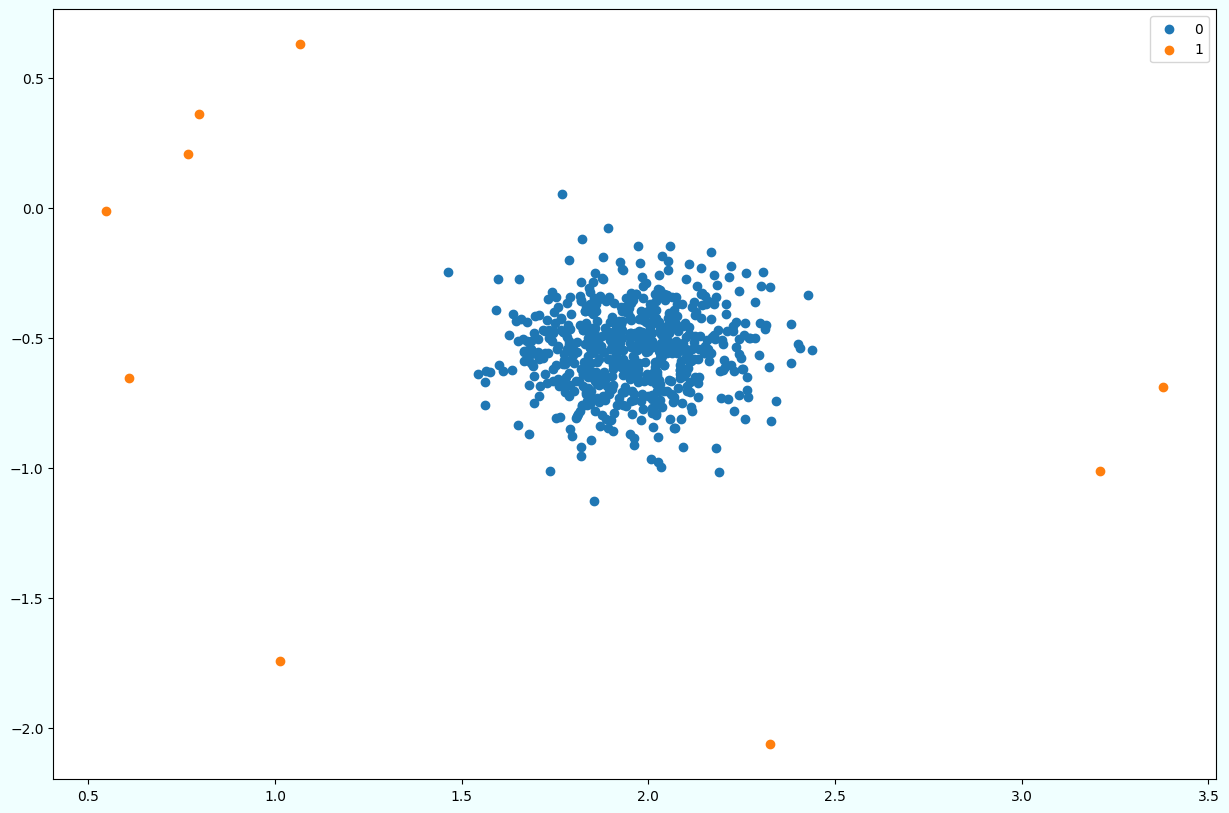

In [168]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()